## Image Classification on CIFAR-10
In this problem we will explore different deep learning architectures for image classification on the CIFAR-10 dataset. Make sure that you are familiar with torch `Tensor`s, two-dimensional convolutions (`nn.Conv2d`) and fully-connected layers (`nn.Linear`), ReLU non-linearities (`F.relu`), pooling (`nn.MaxPool2d`), and tensor reshaping (`view`).

We will use Colab because it has free GPU runtimes available; GPUs can accelerate training times for this problem by 10-100x. **You will need to enable the GPU runtime to use it**. To do so, click "Runtime" above and then "Change runtime type". There under hardware accelerator choose "GPU".

This notebook provides some starter code for the CIFAR-10 problem on HW4, including a completed training loop to assist with some of the Pytorch setup. You'll need to modify this code to implement the layers required for the assignment, but this provides a working training loop to start from.

*Note: GPU runtimes are limited on Colab. Limit your training to short-running jobs (around 20mins or less) and spread training out over time, if possible. Colab WILL limit your usage of GPU time, so plan ahead and be prepared to take breaks during training.* We also suggest performing your early coding/sweeps on a small fraction of the dataset (~10%) to minimize training time and GPU usage.

In [1]:
import torch
from torch import nn
import numpy as np

from typing import Tuple, Union, List, Callable
from torch.optim import SGD
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Let's verify that we are using a gpu:

In [2]:
assert torch.cuda.is_available(), "GPU is not available, check the directions above (or disable this assertion to use CPU)"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)  # this should print out CUDA

cuda


To use the GPU you will need to send both the model and data to a device; this transfers the model from its default location on CPU to the GPU.

Note that torch operations on Tensors will fail if they are not located on the same device.

```python
model = model.to(DEVICE)  # Sending a model to GPU

for x, y in tqdm(data_loader):
  x, y = x.to(DEVICE), y.to(DEVICE)
```
When reading tensors you may need to send them back to cpu, you can do so with `x = x.cpu()`.

Let's load CIFAR-10 data. This is how we load datasets using PyTorch in the real world!

In [3]:
train_dataset = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Here, we'll use the torch `DataLoader` to wrap our datasets. `DataLoader`s handle batching, shuffling, and iterating over data; they can also be useful for building more complex input pipelines that perform transfoermations such as data augmentation.

In [29]:
batch_size = 1024
# batch_size= 4

train_dataset, val_dataset = random_split(train_dataset, [int(0.9 * len(train_dataset)), int( 0.1 * len(train_dataset))])

# Create separate dataloaders for the train, test, and validation set
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

## For Reference: Logistic Regression

This problem is about deep learning architectures, not pytorch. We are providing an implementation of logistic regression using SGD in torch, which can serve as a template for the rest of your implementation in this problem.

Before we get started, let's take a look at our data to get an understanding of what we are doing. CIFAR-10 is a dataset containing images split into 10 classes.

A single batch of images has shape: torch.Size([128, 3, 32, 32])
A single RGB image has 3 channels, width 32, and height 32.
Size of a batch of images flattened with view: torch.Size([128, 3072])
Size of a batch of images flattened with flatten: torch.Size([128, 3072])
True
This image is labeled as class ship


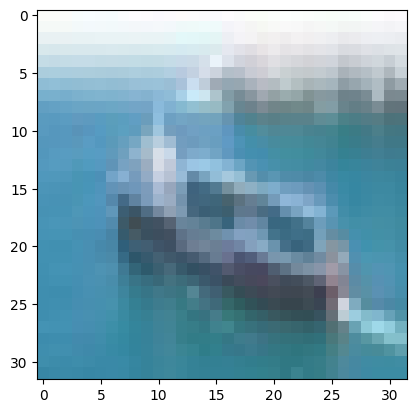

In [5]:
imgs, labels = next(iter(train_loader))
print(f"A single batch of images has shape: {imgs.size()}")
example_image, example_label = imgs[0], labels[0]
c, w, h = example_image.size()
print(f"A single RGB image has {c} channels, width {w}, and height {h}.")

# This is one way to flatten our images
batch_flat_view = imgs.view(-1, c * w * h)
print(f"Size of a batch of images flattened with view: {batch_flat_view.size()}")

# This is another equivalent way
batch_flat_flatten = imgs.flatten(1)
print(f"Size of a batch of images flattened with flatten: {batch_flat_flatten.size()}")

# The new dimension is just the product of the ones we flattened
d = example_image.flatten().size()[0]
print(c * w * h == d)

# View the image
t =  torchvision.transforms.ToPILImage()
plt.imshow(t(example_image))

# These are what the class labels in CIFAR-10 represent. For more information,
# visit https://www.cs.toronto.edu/~kriz/cifar.html
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
           "horse", "ship", "truck"]
print(f"This image is labeled as class {classes[example_label]}")


In this problem, we will attempt to predict what class an image is labeled as.

First, let's create our model. For a linear model we could flatten the data before passing it into the model, but that is not be the case for the convolutional neural network.

In [6]:
def linear_model() -> nn.Module:
    """Instantiate a linear model and send it to device."""
    model =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(d, 10)
         )
    return model.to(DEVICE)

In [7]:
def fully_connected_model(M, input_dim=3072, output_dim=10):
    """Instantiate a fully connected model with one hidden layer and send it to device."""
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_dim, M),  # First fully-connected layer with size M
        nn.ReLU(),                # ReLU activation function
        nn.Linear(M, output_dim)  # Second fully-connected layer with size 10 (output layer)
    )
    return model.to(DEVICE) 

In [8]:
def conv_model(M, k, N, output_dim=10, input_size=(3, 32, 32)):
    """Instantiate a convolutional neural network model with one conv layer followed by max-pooling and a fully connected layer, and send it to device."""
    # Define the model
    model = nn.Sequential(
        nn.Conv2d(input_size[0], M, k, padding=k//2),  # Convolutional layer with 'same' padding
        nn.ReLU(),  # Activation function
        nn.MaxPool2d(N),  # Max pooling layer
        nn.Flatten(),  # Flatten the output
        # No need to calculate the size manually, nn.Linear will infer it
        nn.Linear(M * ((input_size[1] // N) ** 2), output_dim)  # Fully connected layer
    )
    return model.to(DEVICE)

Let's define a method to train this model using SGD as our optimizer.

In [9]:
def train(
    model: nn.Module, optimizer: SGD,
    train_loader: DataLoader, val_loader: DataLoader,
    epochs: int = 20
)-> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Trains a model for the specified number of epochs using the loaders.

    Returns:
    Lists of training loss, training accuracy, validation loss, validation accuracy for each epoch.
    """

    loss = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for e in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        # Main training loop; iterate over train_loader. The loop
        # terminates when the train loader finishes iterating, which is one epoch.
        for (x_batch, labels) in train_loader:
            x_batch, labels = x_batch.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            labels_pred = model(x_batch)
            batch_loss = loss(labels_pred, labels)
            train_loss = train_loss + batch_loss.item()

            labels_pred_max = torch.argmax(labels_pred, 1)
            batch_acc = torch.sum(labels_pred_max == labels)
            train_acc = train_acc + batch_acc.item()

            batch_loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / (batch_size * len(train_loader)))

        # Validation loop; use .no_grad() context manager to save memory.
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for (v_batch, labels) in val_loader:
                v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
                labels_pred = model(v_batch)
                v_batch_loss = loss(labels_pred, labels)
                val_loss = val_loss + v_batch_loss.item()

                v_pred_max = torch.argmax(labels_pred, 1)
                batch_acc = torch.sum(v_pred_max == labels)
                val_acc = val_acc + batch_acc.item()
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_acc / (batch_size * len(val_loader)))

    return train_losses, train_accuracies, val_losses, val_accuracies


For this problem, we will be using SGD. The two hyperparameters for our linear model trained with SGD are the learning rate and momentum. Only learning rate will be searched for in this example. A grid search approach is used here, but you may find a random search approach to be less computationally expensive. One way to accomplish this is to define a set of values for each hyperparameter (e.g. 5 different learning rates, 4 different values for momentum, etc.). Then, for a set number of iterations (e.g. 20), randomly select a value from each hyperparamter set to create a new random configuration.

Note: We ask you to plot the accuracies for the best 3 models for each structure, so you will need to either return multiple sets of hyperparameters from your parameter search or run the hyperparameter search multiple times.

In [11]:
def parameter_search(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model_fn:Callable[[], nn.Module]
) -> float:
    """
    Parameter search for our linear model using SGD.

    Args:
    train_loader: the train dataloader.
    val_loader: the validation dataloader.
    model_fn: a function that, when called, returns a torch.nn.Module.

    Returns:
    The learning rate with the least validation loss.
    NOTE: you may need to modify this function to search over and return
     other parameters beyond learning rate.
    """
    num_iter = 4
    best_loss = torch.tensor(np.inf)
    best_lr = 0.0
    best_M = 0.0
    best_k=0.0
    best_N=0.0
    num_epoch = 100
    lrs = torch.linspace(0.02, 0.1, num_iter)
    # Possible learning rates to try
    lrs = [0.001, 0.01]

    # Possible momentum values to try
    momentums = [0.5, 0.7, 0.9]

    # Possible numbers of filters to try in the convolutional layer
    Ms = [64, 128, 256]

    # Possible kernel sizes to try for the convolutional layer
    ks = [3, 5, 7]

    # Possible pooling sizes to try after the convolutional layer
    Ns = [2, 4]

    # Number of epochs for each training run
    num_epoch = 20
    for M in Ms:
        for k in ks:
            for N in Ns:
                for moment in momentums:
                    for lr in lrs:
                        
                        model = model_fn(M, k, N)
                        optim = SGD(model.parameters(), lr, momentum=moment)

                        train_loss, train_acc, val_loss, val_acc = train(
                            model,
                            optim,
                            train_loader,
                            val_loader,
                            epochs=num_epoch
                            )
                        print(f"result for learning rate {lr}, hidden layer {M}, kernel {k}, pool size:{N}, batch size {batch_size}, momentum: {moment}")
                        print(f'val_loss: {min(val_loss)}')
                        if min(val_loss) < best_loss:
                            best_loss = min(val_loss)
                            best_lr = lr
                            best_M = M
                            best_moment = moment
                            best_k = k
                            best_N = N

    return train_loss, train_acc, val_loss, val_acc, best_lr, best_M, best_k, best_N, best_moment, num_epoch

Now that we have everything, we can train and evaluate our model.

In [ ]:
train_loss, train_accuracy, val_loss, val_accuracy, best_lr, best_M, best_k, best_N, best_moment, num_epoch = parameter_search(train_loader, val_loader, conv_model)

result for learning rate 0.01, hidden layer 64, kernel 5, pool size:4, batch size 128, momentum: 0.9
val_loss: 0.9603123307228089

result for learning rate 0.01, hidden layer 64, kernel 7, pool size:4, batch size 128, momentum: 0.7
val_loss: 0.9896579176187515

result for learning rate 0.01, hidden layer 128, kernel 3, pool size:4, batch size 128, momentum: 0.9
val_loss: 0.9383217379450798

result for learning rate 0.01, hidden layer 128, kernel 5, pool size:2, batch size 128, momentum: 0.9
val_loss: 0.9766788065433503

In [33]:
best_M = 4096
# best_k = 5
# best_N = 2
best_lr = 0.02
best_moment = 0.8
num_epoch = 100
model = fully_connected_model(best_M)
optimizer = SGD(model.parameters(), best_lr, momentum=best_moment)

In [34]:
# We are only using 20 epochs for this example. You may have to use more.
train_loss, train_accuracy, val_loss, val_accuracy = train(
    model, optimizer, train_loader, val_loader, num_epoch
)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

Plot the training and validation accuracy for each epoch.

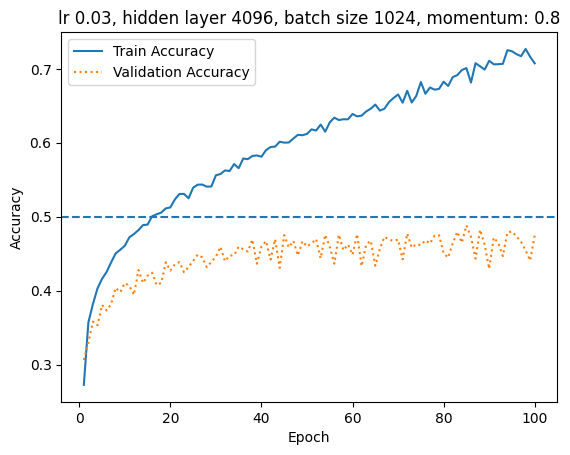

In [32]:
epochs = range(1, num_epoch+1)
plt.plot(epochs, train_accuracy, label="Train Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy", linestyle='dotted')
plt.axhline(y=0.5, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title(f"lr {best_lr}, hidden layer {best_M}, batch size {batch_size}, momentum: {best_moment}")
plt.show()

The last thing we have to do is evaluate our model on the testing data.

In [53]:
def evaluate(
    model: nn.Module, loader: DataLoader
) -> Tuple[float, float]:
    """Computes test loss and accuracy of model on loader."""
    loss = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for (batch, labels) in loader:
            batch, labels = batch.to(DEVICE), labels.to(DEVICE)
            y_batch_pred = model(batch)
            batch_loss = loss(y_batch_pred, labels)
            test_loss = test_loss + batch_loss.item()

            pred_max = torch.argmax(y_batch_pred, 1)
            batch_acc = torch.sum(pred_max == labels)
            test_acc = test_acc + batch_acc.item()
        test_loss = test_loss / len(loader)
        test_acc = test_acc / (batch_size * len(loader))
        return test_loss, test_acc

In [54]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.36689453125


The rest is yours to code. You can structure the code any way you would like.

We do advise making using code cells and functions (train, search, predict etc.) for each subproblem, since they will make your code easier to debug.

Also note that several of the functions above can be reused for the various different models you will implement for this problem. For example, you don't need to write a new `evaluate()`.